<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grafos de atención

En este cuaderno de Jupyter Notebook se realiza un análisis de los residuos alostéricos de dos GPCR: receptor A2A de adenosina y receptor beta-2 adrenérgico. Ambos son receptores cuyo mecanismo de transmisión de la señal se basa en el alosterismo.

En este cuaderno se estudian los potenciales residuos de interés en el alosterismo con fundamentos en el análisis propio de la teoría de grafos, junto con los estudios de atención generados con ESM-2. Por tanto, para generar los grafos es fundamental tener los datos de atención en formato CSV. En el archivo CSV se contienen 5 columnas: Layer,Head,From (Query Position),To (Allosteric Position),Attention Score.

Cada nodo del grafo representa el carbono alfa del aminoácido correspondiente y dos nodos se unen si la distancia entre los carbonos alfa se encuentra entre los 4 y los 8 angstroms. Además, el nodo puede tener un tamaño u otro en función de la medida de centralidad de intermediación, y su color varía en función de la atención.

In [1]:
# Instalación de librerías necesarias para el análisis:
# igraph para la construcción de los grafos de proteínas
# biopython para extraer los datos de las coordenadas de los átomos de la pro-
# teína en formato .cif

!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.8 MB/s eta 0:00:00


# Descargar .mmCIF para hacer el grafo

Para esta parte del análisis es esencial tener la posición de los residuos en la secuencia de la proteína. Sin embargo, en los archivos .pdb no suele ser común que se almacene las posiciones de esa manera, sino que lo hace en el indexado auth, que se corresponde con el indexado de la estructura tridimensional. Para corregir esto trabajamos con el formato .cif, que si recoge la posición del aminoácido en la secuencia lineal.

In [2]:
# Al definir esta función podemos usarla para descargar archivos .mmCIF desde
# el RCSB PDB para trabajar con ellos con más facilidad
import os
import requests

def download_mmcif(pdb_id, save_dir="mmcif_files"):
    """
    Descarga el archivo .mmCIF para el PDB ID dado desde el servidor de RCSB.

    Args:
        pdb_id (str): Identificador de la proteína en el PDB (e.g., "2YDO").
        save_dir (str): Carpeta donde se guardará el archivo.

    Returns:
        str: Ruta al archivo descargado.
    """
    pdb_id = pdb_id.lower()
    url = f"https://files.rcsb.org/download/{pdb_id}.cif"

    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{pdb_id}.cif")

    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, "w") as f:
            f.write(response.text)
        print(f"✅ Archivo descargado: {file_path}")
        return file_path
    else:
        raise ValueError(f"No se pudo descargar el archivo para PDB ID '{pdb_id}'. Código de estado: {response.status_code}")


Estas son las cuatro estructuras con las que trabajamos. Con este bloque se descargan sus respectivos archivos en formato .cif

In [3]:
# Descarga los archivos .cif de las estructuras con las que vamos a trabajar.

pdbs = ["2YDO", "5G53", "2R4R", "3SN6"]
for pdb in pdbs:
  download_mmcif(pdb)

✅ Archivo descargado: mmcif_files/2ydo.cif
✅ Archivo descargado: mmcif_files/5g53.cif
✅ Archivo descargado: mmcif_files/2r4r.cif
✅ Archivo descargado: mmcif_files/3sn6.cif


# PSN de atención

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 2R4R: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G_4ldo"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G_3sn6"]

In [4]:
# Diccionario de sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi": [113, 203, 204, 207, 293, 296, 308, 312],
    "beta2AR_G":[68, 130, 131, 139, 141],
    }

## PSN de 2YDO

<ipython-input-5-9ea7eda104b7>:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")



Nodos con atención y betweenness por encima del percentil 85:
  Asn280 | Atención: 0.5628 | Betweenness: 1406.5264
  His278 | Atención: 0.3637 | Betweenness: 2262.3383
  Ser281 | Atención: 0.3387 | Betweenness: 1601.9062
  His250 | Atención: 0.2274 | Betweenness: 1357.8248
  Pro285 | Atención: 0.1921 | Betweenness: 2055.4818
  Val282 | Atención: 0.1102 | Betweenness: 2561.9771
  Asp170 | Atención: 0.0792 | Betweenness: 1420.6355
  Val172 | Atención: 0.0708 | Betweenness: 2289.3266
  Glu312 | Atención: 0.0311 | Betweenness: 1970.7628


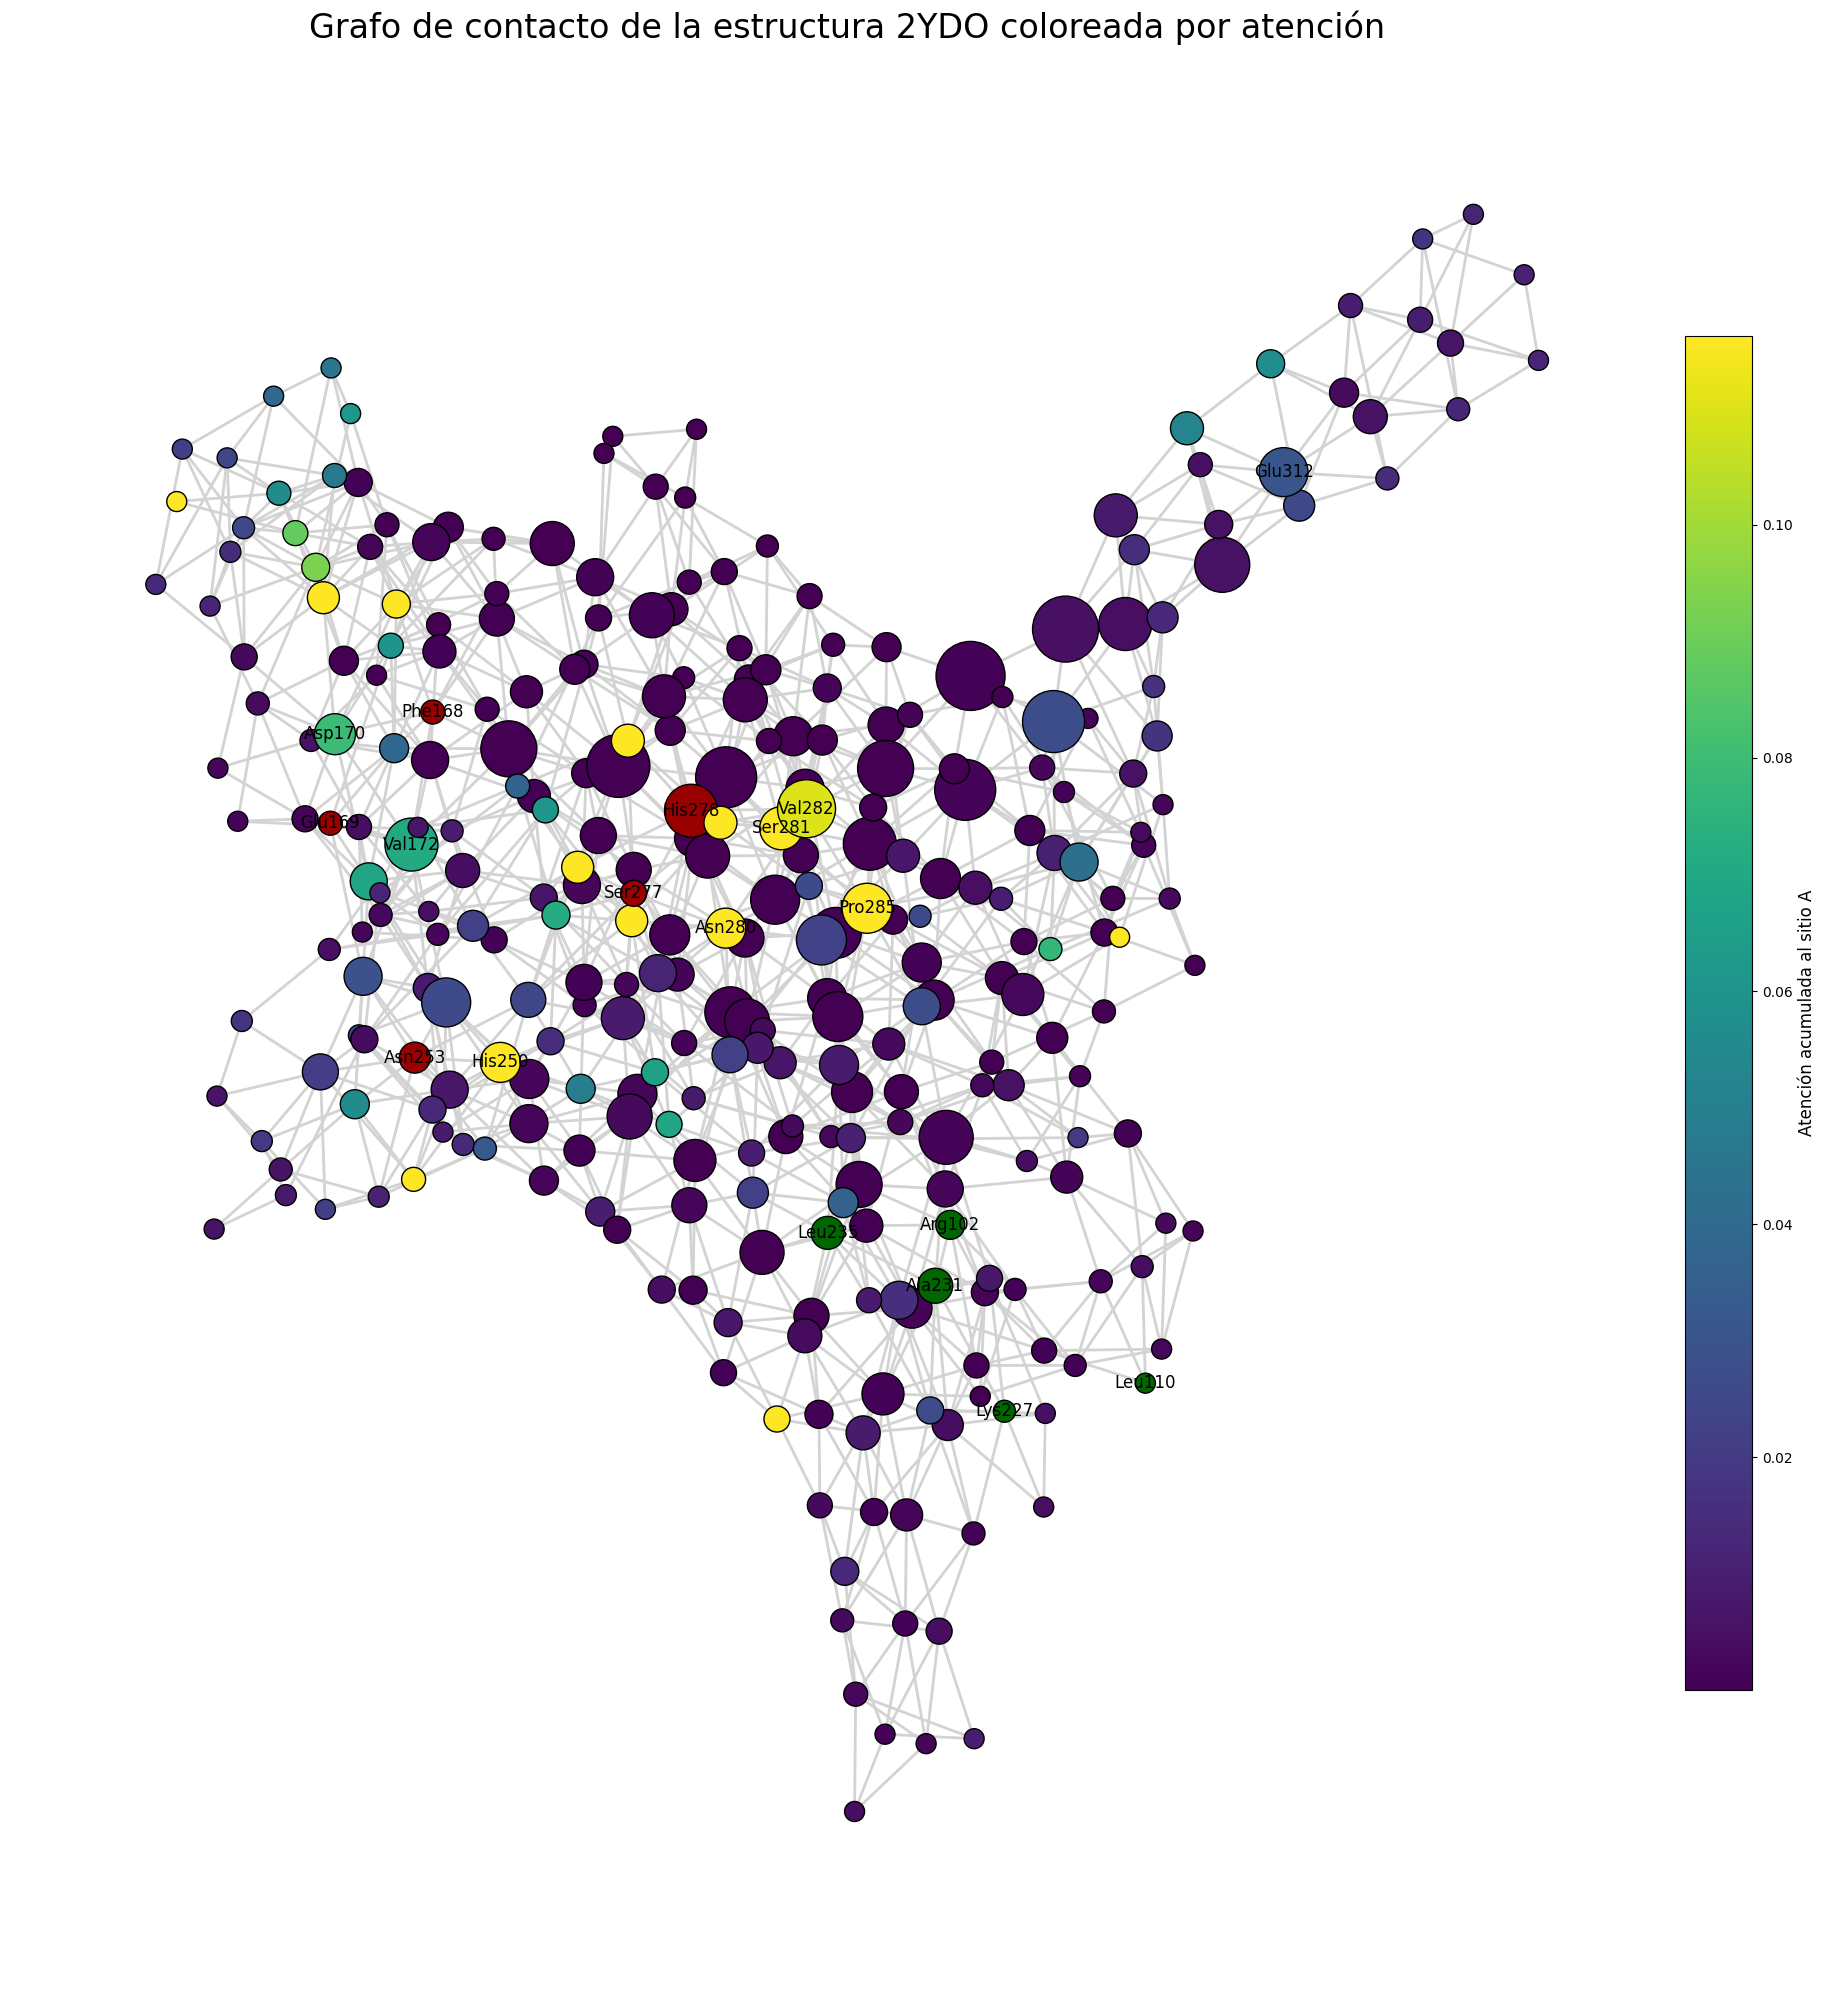

In [5]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "2YDO"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_a2a.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["A2A_adenosine"]
sitio_O = sites["A2A_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)


# === Calcular el percentil para betweenness y atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# for idx in sitio_A + sitio_O + [n["index"] for n in nodos_destacados]:
#     g.vs[idx]["frame_color"] = (1, 1, 1)  # Blanco para nodos destacados


# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.4f} | Betweenness: {nodo['betweenness']:.4f}")


# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(650, 650),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.0001, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Grafo de contacto de la estructura 2YDO coloreada por atención", fontsize=24)
plt.tight_layout()
plt.savefig("grafo_atencion_2YDO.pdf", format="pdf")
plt.show()


## PSN de 5G53

<ipython-input-7-996900f4570b>:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")



Nodos con atención y betweenness por encima del percentil 85:
  Asn280 | Atención: 0.5628 | Betweenness: 2278.6096
  His278 | Atención: 0.3637 | Betweenness: 2797.5184
  Ser281 | Atención: 0.3387 | Betweenness: 1410.9950
  Val282 | Atención: 0.1102 | Betweenness: 1512.1648
  Val172 | Atención: 0.0708 | Betweenness: 1524.3375
  Arg296 | Atención: 0.0418 | Betweenness: 1206.6977


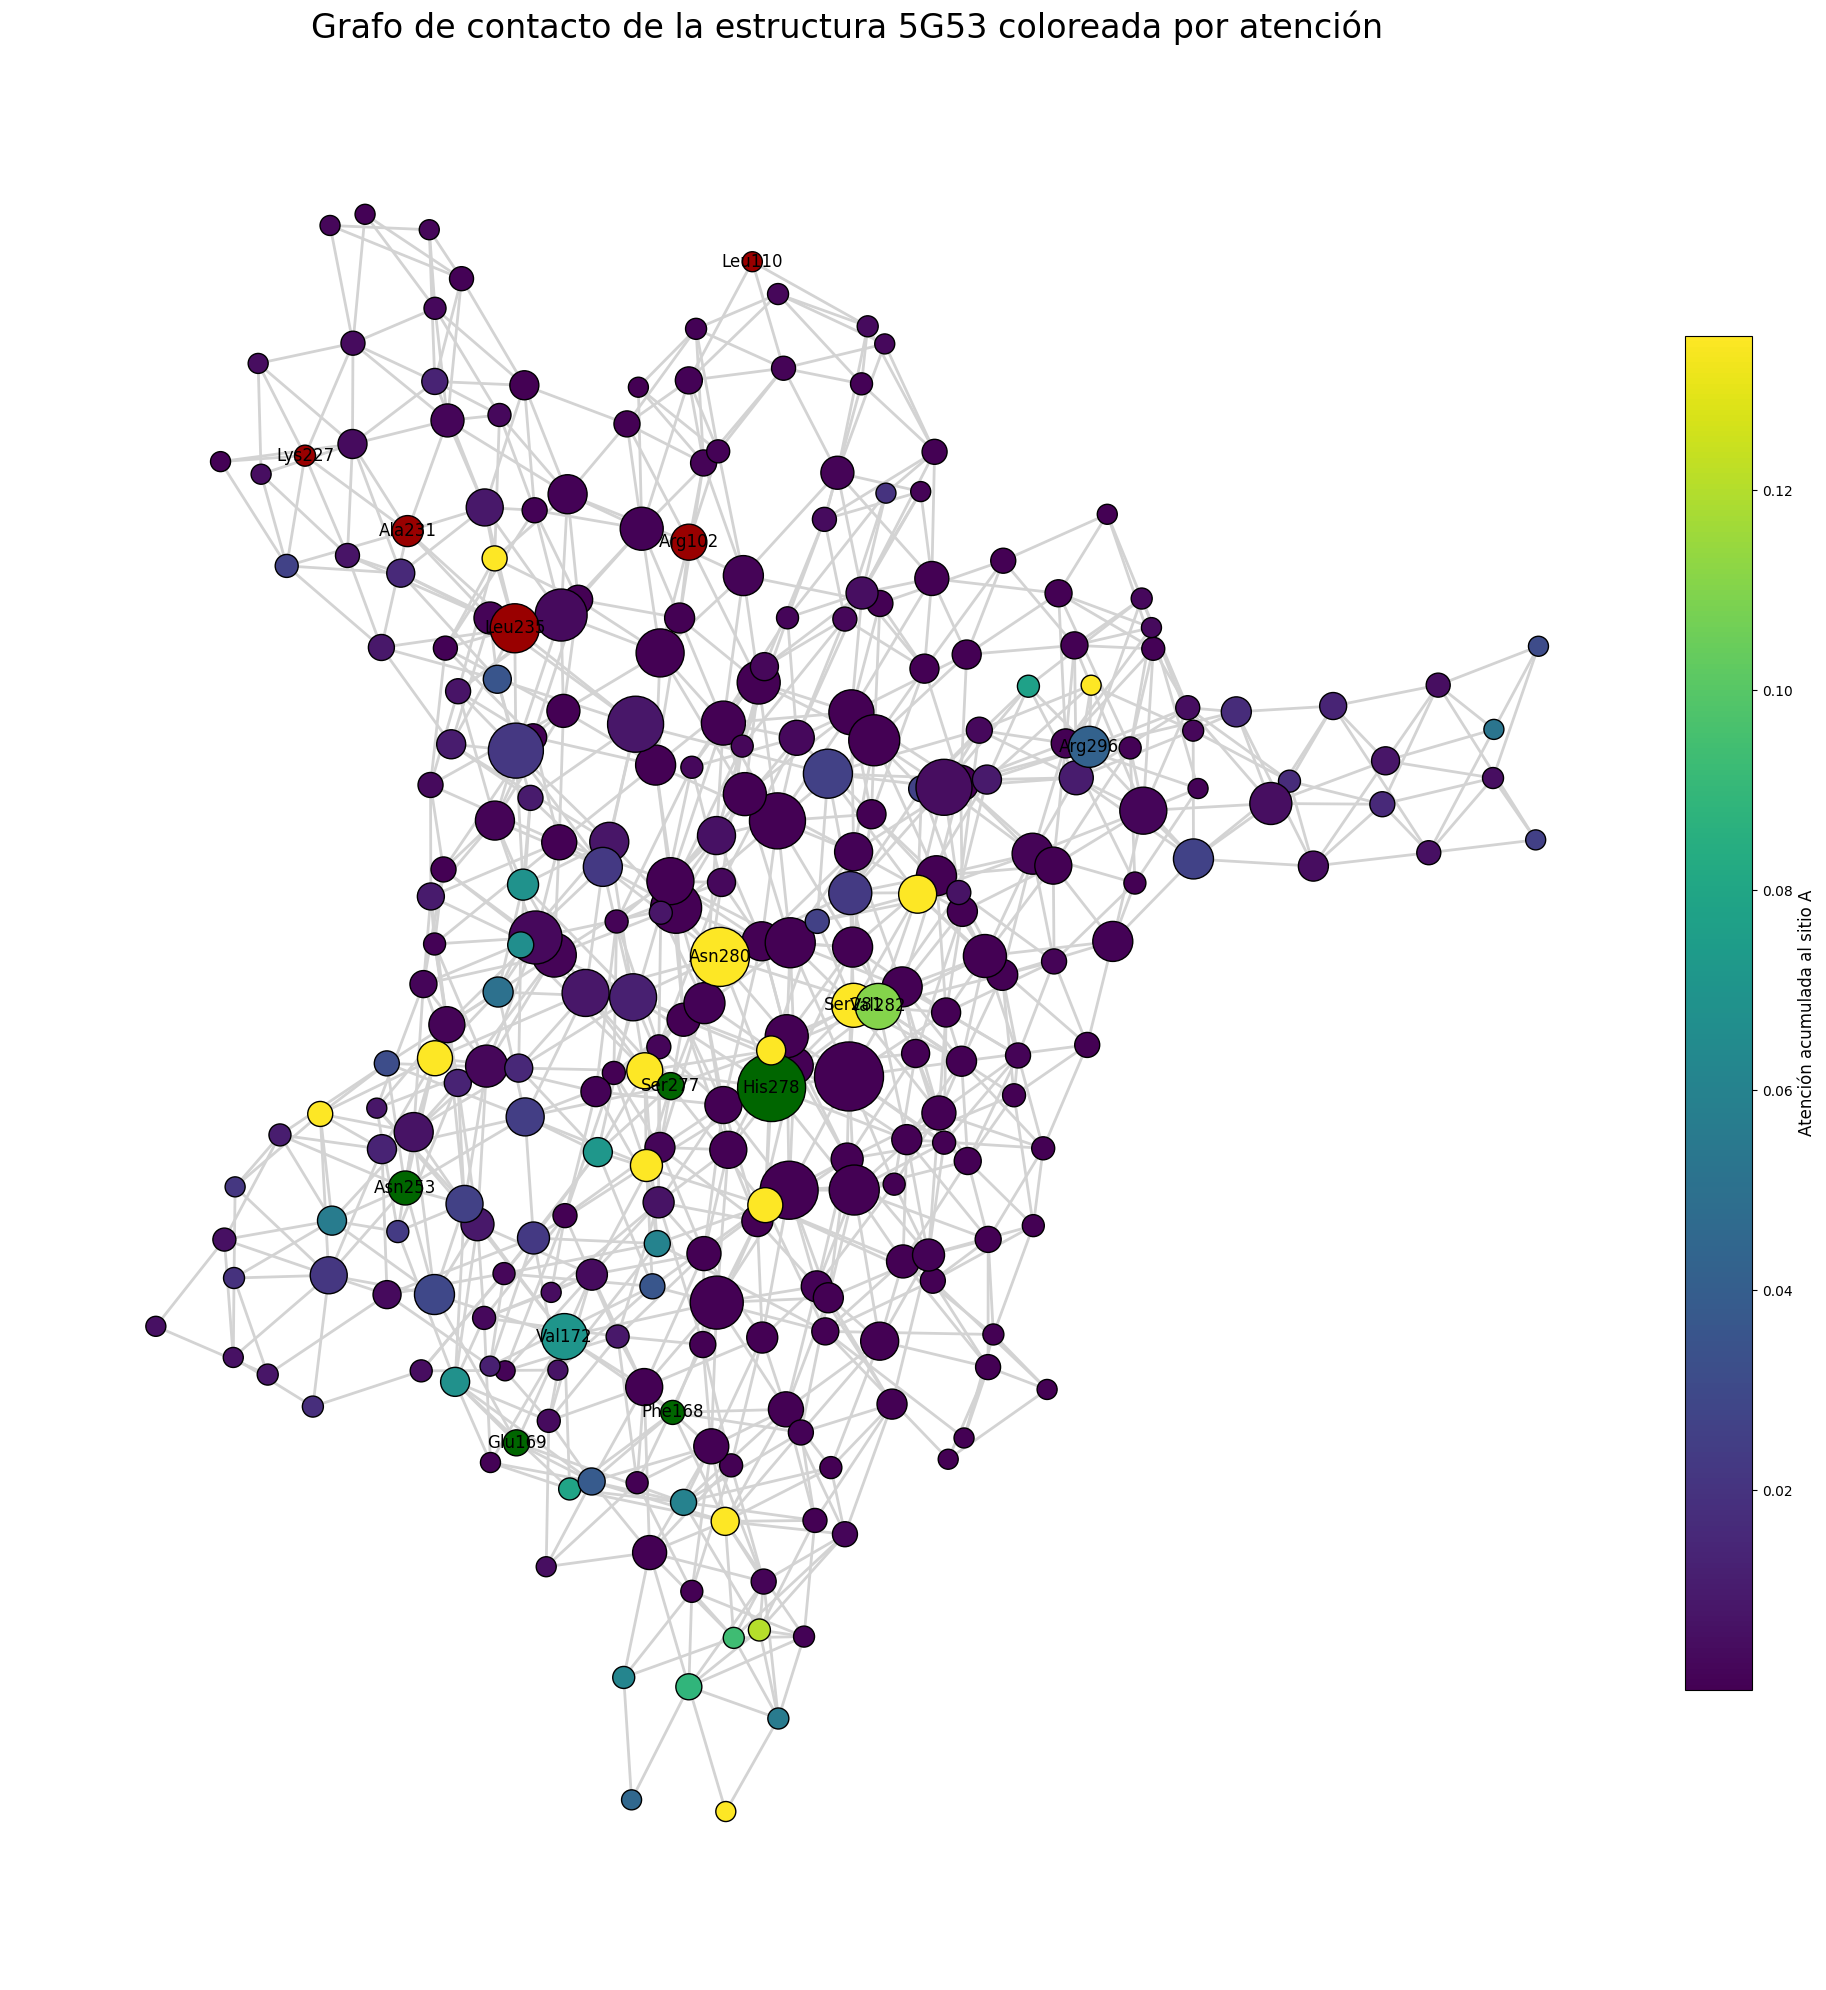

In [ ]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "5G53"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_a2a.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["A2A_adenosine"]
sitio_O = sites["A2A_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# for idx in sitio_A + sitio_O + [n["index"] for n in nodos_destacados]:
#     g.vs[idx]["frame_color"] = (1, 1, 1)  # Blanco para nodos destacados


# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.4f} | Betweenness: {nodo['betweenness']:.4f}")


# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(650, 650),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.0001, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Grafo de contacto de la estructura 5G53 coloreada por atención", fontsize=24)
plt.tight_layout()
plt.savefig("grafo_atencion_5G53.pdf", format="pdf")
plt.show()


## PSN de 2R4R

<ipython-input-8-54d3e3720de1>:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")



Nodos con atención y betweenness por encima del percentil 85:
  Leu124 | Atención: 0.1094 | Betweenness: 1564.5194
  Pro323 | Atención: 0.0924 | Betweenness: 1149.3190
  Thr123 | Atención: 0.0737 | Betweenness: 1482.3093
  Ala226 | Atención: 0.0570 | Betweenness: 1051.2868


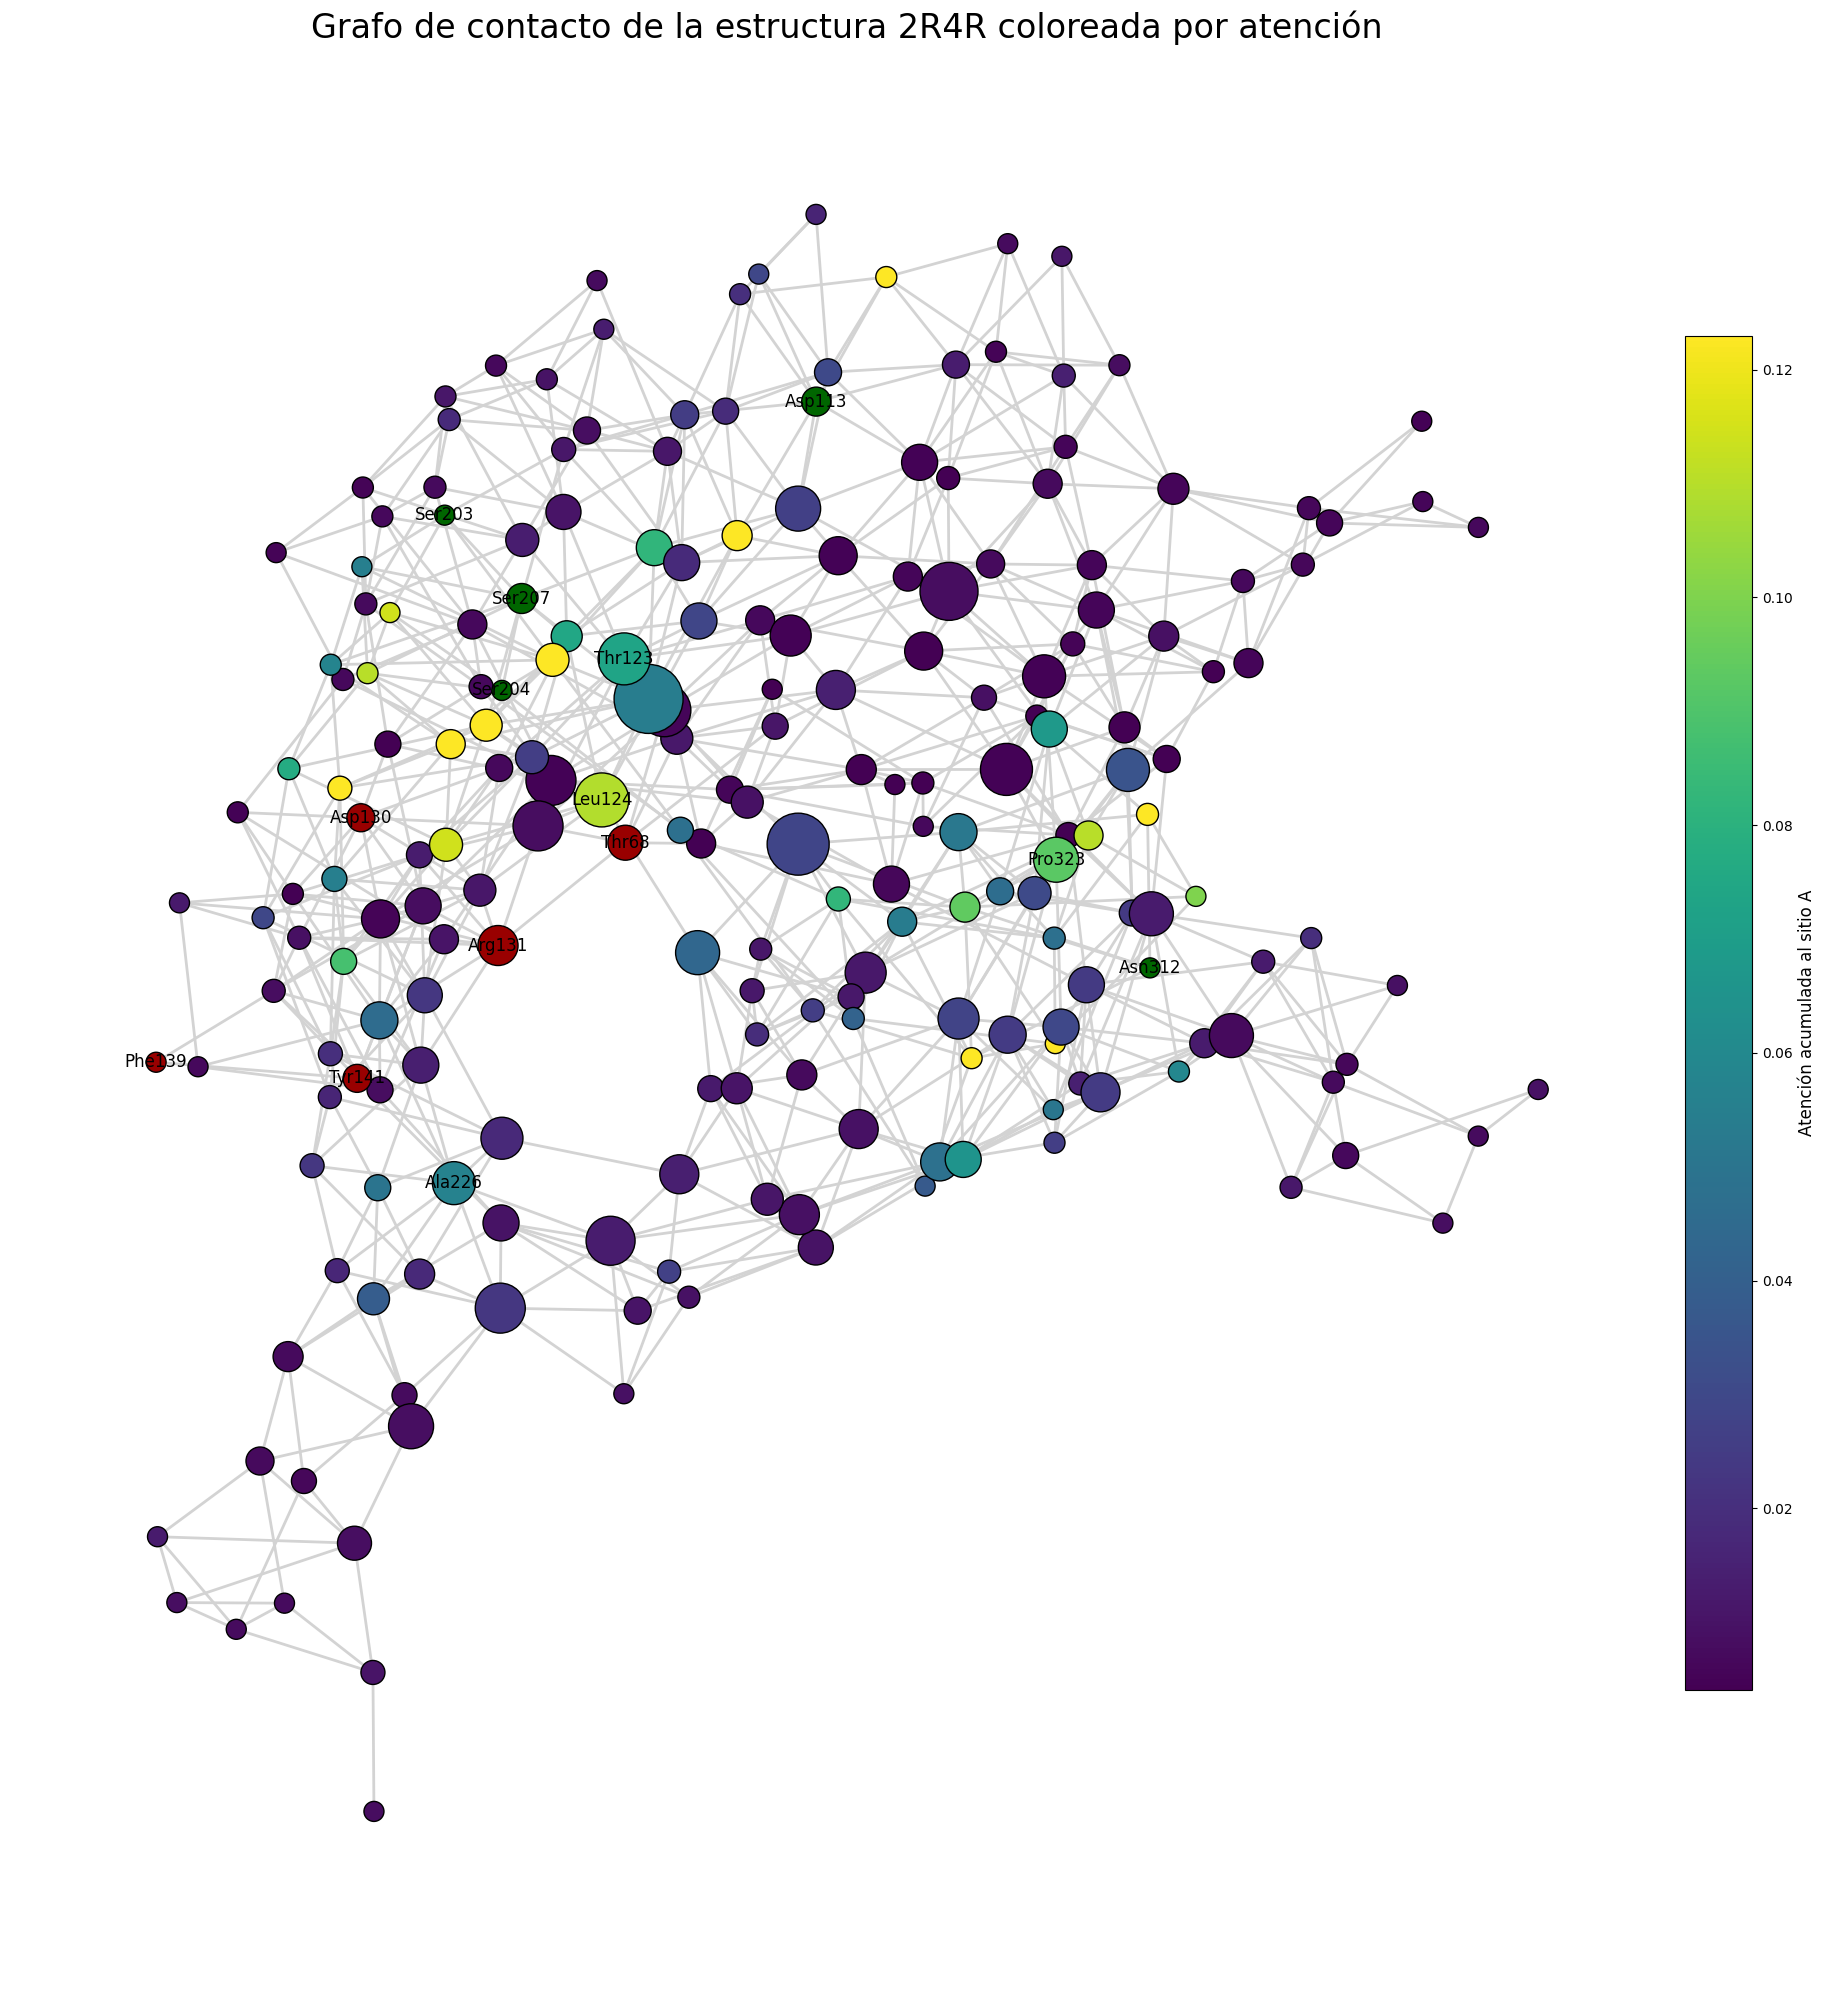

In [ ]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Configuraciones iniciales
pdb_id = "2R4R"
chain_id = "A"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_adrb2.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["beta2AR_epi"]
sitio_O = sites["beta2AR_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue and residue.id[0] == " ":
                    label_seq_id = residue.get_id()[1]
                    coord = residue["CA"].get_coord()
                    resname = residue.get_resname().capitalize()
                    resnum = residue.get_id()[1]
                    resnum_to_resname[resnum] = resname
                    CA_coord.append(coord)
                    CA_info.append((chain.id, label_seq_id, "", resname))


# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# for idx in sitio_A + sitio_O + [n["index"] for n in nodos_destacados]:
#     g.vs[idx]["frame_color"] = (1, 1, 1)  # Blanco para nodos destacados


# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.4f} | Betweenness: {nodo['betweenness']:.4f}")


# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(650, 650),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.0001, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Grafo de contacto de la estructura 2R4R coloreada por atención", fontsize=24)
plt.tight_layout()
plt.savefig("grafo_atencion_2R4R.pdf", format="pdf")
plt.show()


## PSN de 3SN6

La estructura de 3SN6 se caracteriza por ser una proteína de fusión entre una endolisina y el receptor beta-2 adrenérgico. Por ello, primero eliminaremos aquellos aminoácidos que forman parte de la endolisina para que no interfieran en el análisis.

<ipython-input-9-1e903e7de9ff>:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")



Nodos con atención y betweenness por encima del percentil 85:
  Ala200 | Atención: 0.2889 | Betweenness: 1921.5507
  Phe208 | Atención: 0.2730 | Betweenness: 2417.1322
  Ser207 | Atención: 0.2516 | Betweenness: 1966.0467
  Trp109 | Atención: 0.2137 | Betweenness: 1509.3450
  Tyr316 | Atención: 0.1763 | Betweenness: 2099.7909
  Pro211 | Atención: 0.1584 | Betweenness: 1490.9935
  Val117 | Atención: 0.1430 | Betweenness: 1739.0990
  Met215 | Atención: 0.1145 | Betweenness: 1579.1499
  Pro323 | Atención: 0.0924 | Betweenness: 1470.6881
  Trp286 | Atención: 0.0825 | Betweenness: 1777.0118
  Cys106 | Atención: 0.0796 | Betweenness: 1667.6234
  Ser204 | Atención: 0.0772 | Betweenness: 1693.5931


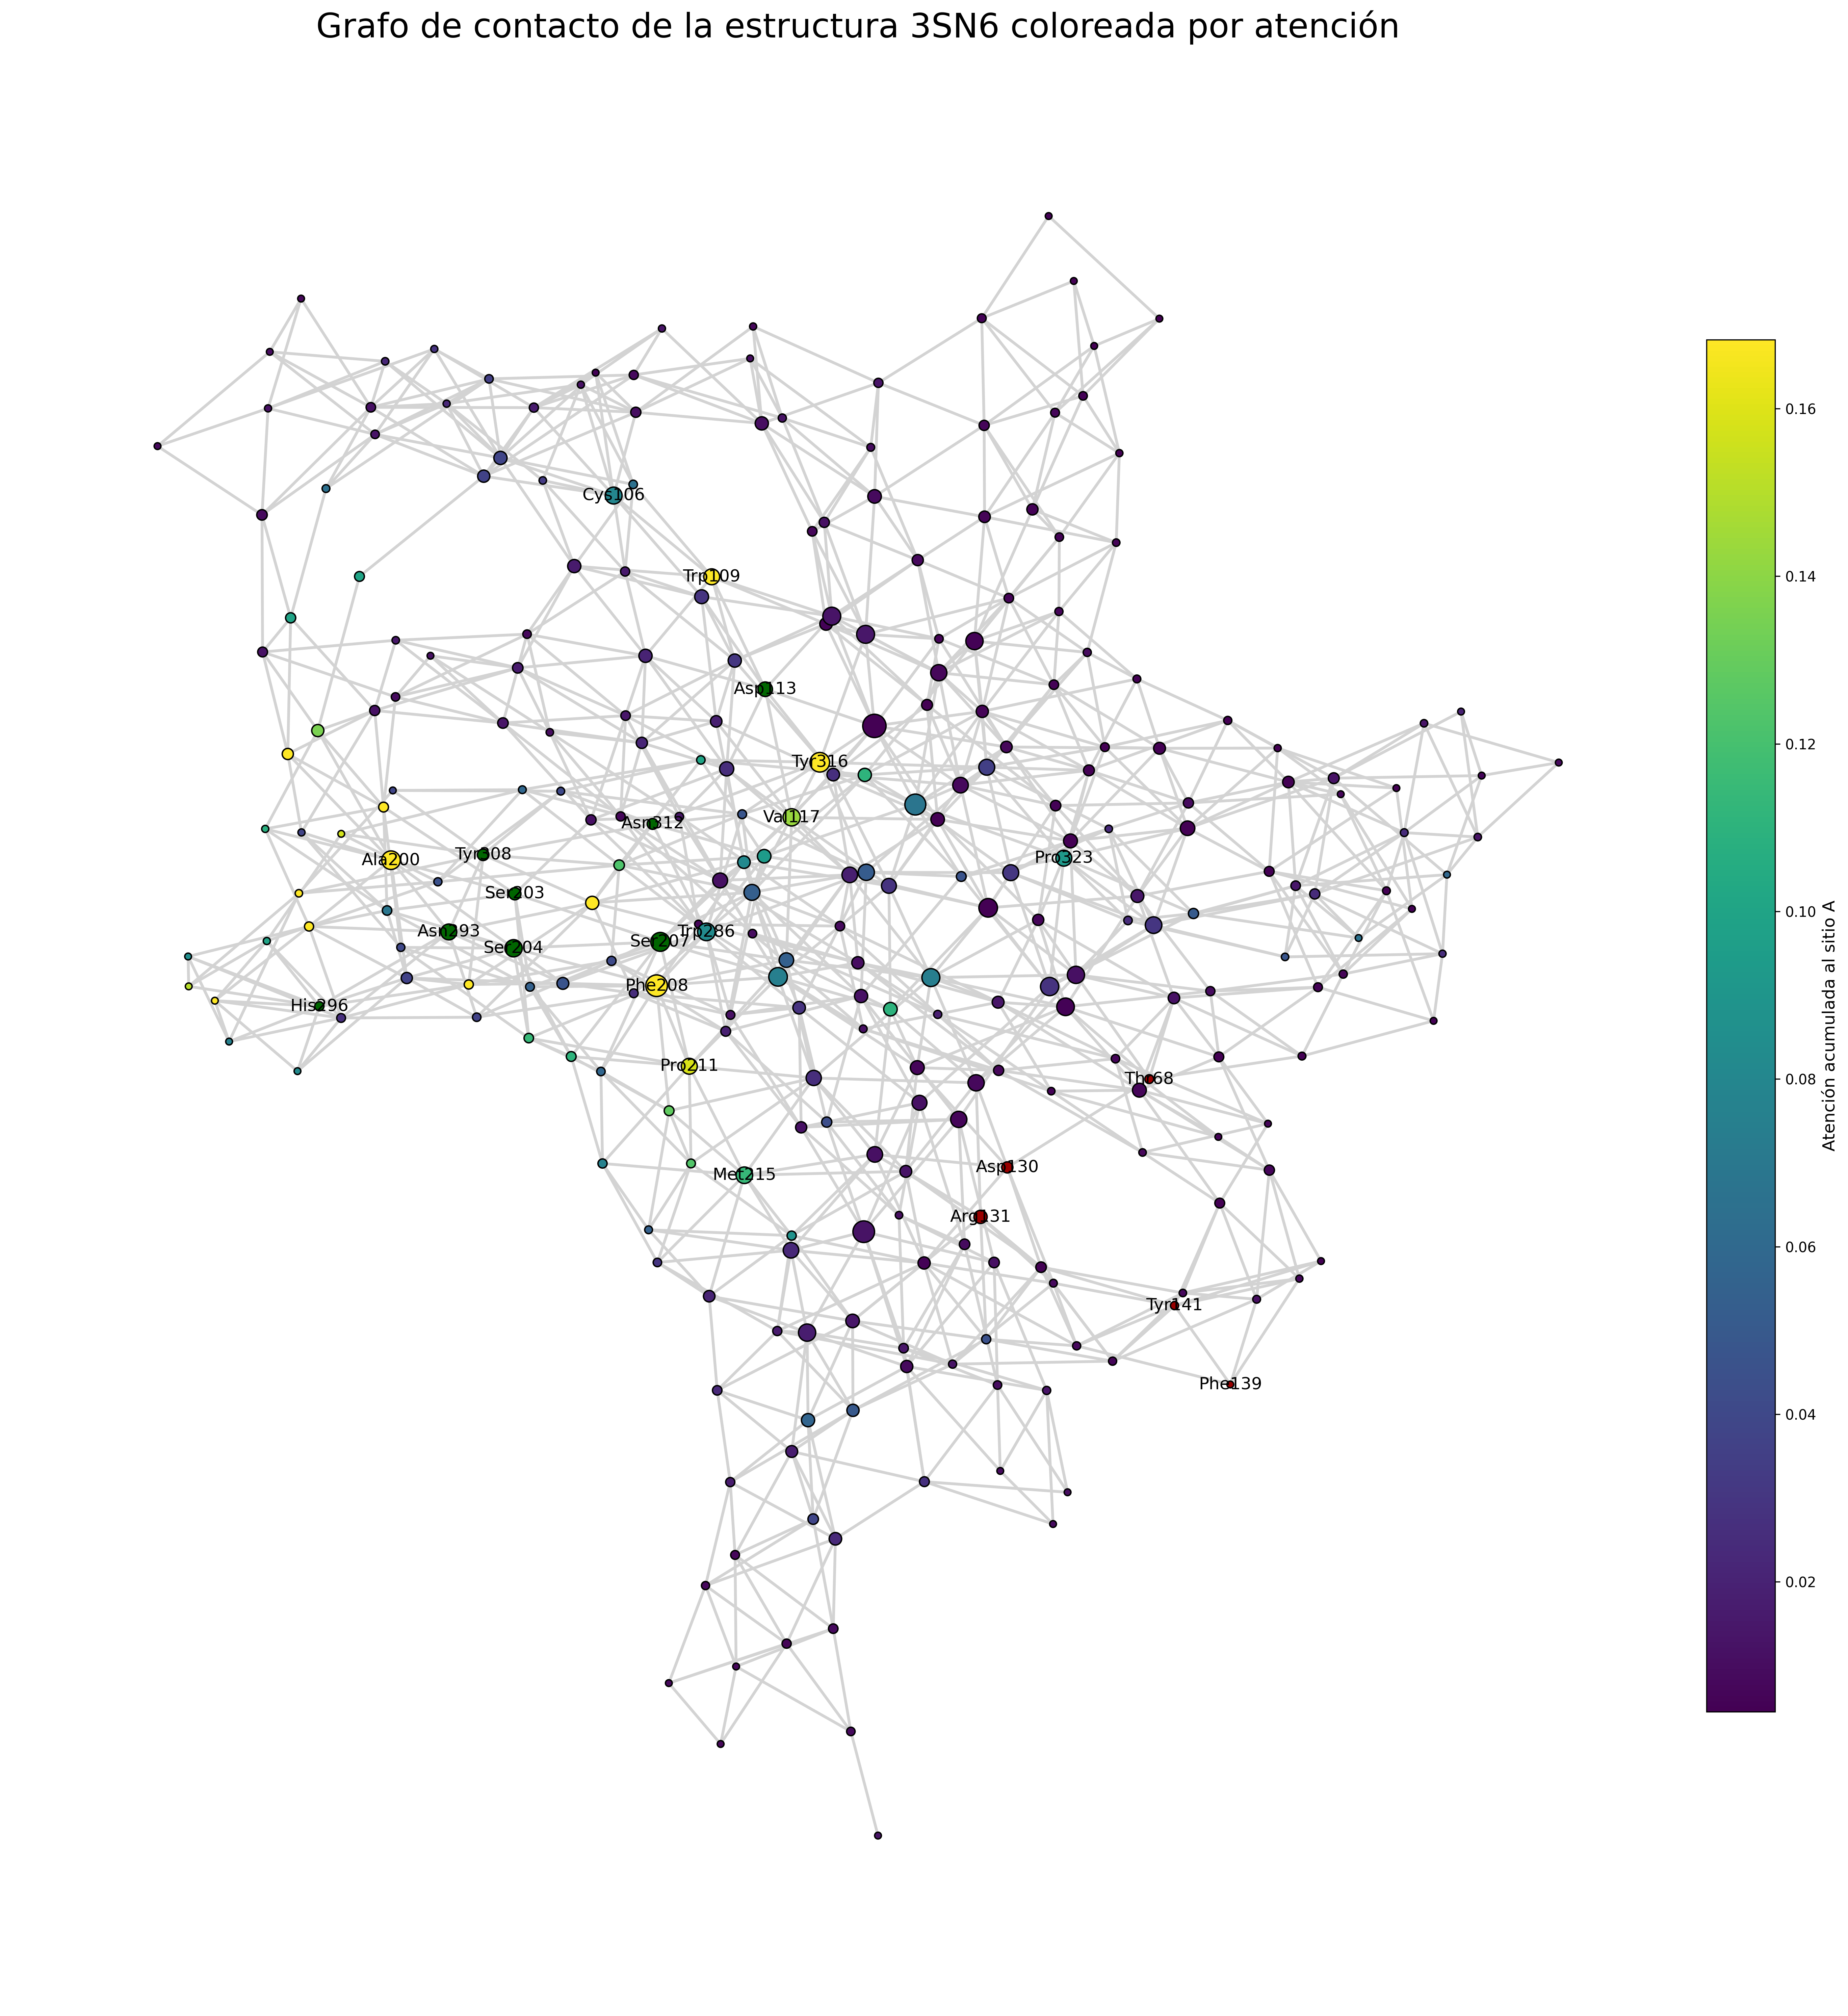

In [ ]:
# Librerías necesarias
from Bio.PDB import MMCIFParser
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from collections import defaultdict
import cairo

# Configuraciones iniciales
pdb_id = "3SN6"
chain_id = "R"
cif_path = f"/content/mmcif_files/{pdb_id.lower()}.cif"
csv_path = "attention_to_allosteric_sites_adrb2.csv"

# Define tus sitios de interés (debes definir el dict 'sites' antes de ejecutar esto)
sitio_A = sites["beta2AR_epi"]
sitio_O = sites["beta2AR_G"]

# Inicializa
np.random.seed(42)
random.seed(42)

# Carga estructura mmCIF
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure(pdb_id, cif_path)

# === Extracción de átomos CA con resname ===
CA_coord = []
CA_info = []
resnum_to_resname = {}

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" not in residue or residue.id[0] != " ":
                    continue
                resnum = residue.get_id()[1]
                if 1002 <= resnum <= 1160:
                    continue  # Eliminar lisozima (hasta residuo 161)

                coord = residue["CA"].get_coord()
                resname = residue.get_resname().capitalize()
                resnum_to_resname[resnum] = resname
                CA_coord.append(coord)
                CA_info.append((chain.id, resnum, "", resname))



# Mapas entre nodos y residuos
node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid[:3]: idx for idx, resid in enumerate(CA_info)}

# Construcción del grafo de contacto
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min, r_max = 4, 8
atom_pairsfilt = {
    (i, j) for i, j in atom_pairs
    if r_min <= np.linalg.norm(CA_coord[i] - CA_coord[j]) <= r_max
}


g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# for idx in sitio_A + sitio_O + [n["index"] for n in nodos_destacados]:
#     g.vs[idx]["frame_color"] = (1, 1, 1)  # Blanco para nodos destacados


# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.4f} | Betweenness: {nodo['betweenness']:.4f}")


# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20), dpi = 300)

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(1000, 1000),
    margin=20
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.0001, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Grafo de contacto de la estructura 3SN6 coloreada por atención", fontsize=24)
plt.tight_layout()
plt.savefig("grafo_atencion_3SN6.pdf", format="pdf")
plt.show()

In [ ]:
# Definir `residue_names` basado en la estructura de la proteína
residue_names = []
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:  # Asegurarnos de que es un carbono alfa
                    residue_names.append(residue.get_resname())  # 'ALA', 'GLY', etc.

# Crear diccionario de residuos con nombre de 3 letras y número
residue_id_map = {
    idx: {"resnum": info[1], "resname": residue_names[idx]}
    for idx, info in enumerate(CA_info)
}

# === Calcular atención acumulada y por TO ===
detailed_attention = {}

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = float(row["Attention Score"])

    if from_pos not in detailed_attention:
        detailed_attention[from_pos] = {}

    if to_pos not in detailed_attention[from_pos]:
        detailed_attention[from_pos][to_pos] = 0.0

    detailed_attention[from_pos][to_pos] += score

# Sumar atención total por residuo
total_attention_per_residue = {
    from_pos: sum(to_scores.values())
    for from_pos, to_scores in detailed_attention.items()
}

# Ordenar residuos por atención total
sorted_residues = sorted(total_attention_per_residue.items(), key=lambda x: x[1], reverse=True)

# Calcular percentil 90
att_values_array = np.array(list(total_attention_per_residue.values()))
threshold = np.percentile(att_values_array, 90)

# === Imprimir resultados ===
print(f"Aminoácidos con atención acumulada superior al percentil 90 ({threshold:.6f}):\n")

for from_pos, total_score in sorted_residues:
    if total_score >= threshold:
        res_data = residue_id_map.get(from_pos, {"resnum": from_pos, "resname": "UNK"})
        print(f"Residuo: {res_data['resname']} {res_data['resnum']} (índice: {from_pos})")
        print(f"  Atención total al sitio A: {total_score:.6f}")
        for to_pos in sitio_A:
            score = detailed_attention[from_pos].get(to_pos, 0.0)
            print(f"    → A{to_pos}: {score:.6f}")
        print("-" * 40)


Aminoácidos con atención acumulada superior al percentil 90 (0.040918):

Residuo: ARG 296 (índice: 280)
  Atención total al sitio A: 0.562803
    → A168: 0.000002
    → A169: 0.000003
    → A253: 0.000079
    → A277: 0.016089
    → A278: 0.546631
----------------------------------------
Residuo: PHE 295 (índice: 279)
  Atención total al sitio A: 0.557517
    → A168: 0.000001
    → A169: 0.000001
    → A253: 0.000034
    → A277: 0.000918
    → A278: 0.556563
----------------------------------------
Residuo: TYR 290 (índice: 274)
  Atención total al sitio A: 0.476749
    → A168: 0.000020
    → A169: 0.000022
    → A253: 0.000381
    → A277: 0.033610
    → A278: 0.442716
----------------------------------------
Residuo: ARG 293 (índice: 277)
  Atención total al sitio A: 0.383612
    → A168: 0.000004
    → A169: 0.000037
    → A253: 0.000121
    → A277: 0.038109
    → A278: 0.345341
----------------------------------------
Residuo: ARG 309 (índice: 293)
  Atención total al sitio A: 0.37364

# Código para generar grafos de PSN

In [ ]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}_filt.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# Betweenness y tamaño de nodos
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    20 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.es["color"] = "lightgray"

# === Lectura de atención desde CSV ===
df_att = pd.read_csv(csv_path)
df_att = df_att[df_att["To (Allosteric Position)"].isin(sitio_A)]

# Agrupación de atención por pares From-To (promediando entre cabezas)
pair_attention = defaultdict(list)

for _, row in df_att.iterrows():
    from_pos = int(row["From (Query Position)"])
    to_pos = int(row["To (Allosteric Position)"])
    score = row["Attention Score"]
    pair_attention[(from_pos, to_pos)].append(score)

# Atención acumulada a sitio A por nodo "From"
attention_scores = {i: 0.0 for i in range(len(CA_info))}

for (from_pos, to_pos), scores in pair_attention.items():
    avg_score = sum(scores) / len(scores)
    key = (chain_id, from_pos, "")
    if key in resid_to_node:
        node = resid_to_node[key]
        attention_scores[node] += avg_score

# Escalado de color
att_values = np.array(list(attention_scores.values()))
vmin = np.percentile(att_values, 5)
vmax = np.percentile(att_values, 95)
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.get_cmap("viridis")

g.vs["color"] = [
    colormap(norm(attention_scores[i]))[:3] for i in range(len(CA_info))
]
g.vs["label"] = [None] * len(g.vs)

# Etiquetar sitios A y O
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.0, 0.4, 0.0)

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        idx = resid_to_node[key]
        _, resnum, _, resname = node_to_resid[idx]
        g.vs[idx]["label"] = f"{resname}{resnum}"
        g.vs[idx]["color"] = (0.6, 0.0, 0.0)

# === Calcular el percentil para betweenness y atención ===
percentile = 85
percentil_btw = np.percentile(g.vs["betweenness"], percentile)
percentil_att = np.percentile(att_values, percentile)

# Extraer nodos que cumplen ambas condiciones
nodos_destacados = []
for i, node in enumerate(g.vs):
    att = attention_scores.get(i, 0.0)
    btw = node["betweenness"]
    if att > percentil_att and btw > percentil_btw:
        resid = node_to_resid[i]
        resnum = resid[1]
        chain = resid[0]
        residue_name = resnum_to_resname.get(resnum, "UNK")
        aa_label = f"{residue_name}{resnum}"
        nodos_destacados.append({
            "index": i,
            "attention": att,
            "betweenness": btw,
            "label": aa_label
        })
        node["label"] = aa_label  # Mostrar etiqueta

g.vs["frame_color"] = [(0,0,0)] * len(g.vs)  # Por defecto negro
# for idx in sitio_A + sitio_O + [n["index"] for n in nodos_destacados]:
#     g.vs[idx]["frame_color"] = (1, 1, 1)  # Blanco para nodos destacados


# Ordenar nodos por atención y betweenness (desc)
nodos_ordenados = sorted(nodos_destacados, key=lambda x: (x["attention"], x["betweenness"]), reverse=True)

# Imprimir resultados
print(f"\nNodos con atención y betweenness por encima del percentil {percentile}:")
print("=" * 60)
for nodo in nodos_ordenados:
    print(f"{nodo['label']:>8} | Atención: {nodo['attention']:.5f} | Betweenness: {nodo['betweenness']:.2f}")


# === Dibujo del grafo ===
layout = g.layout_kamada_kawai()
fig, ax = plt.subplots(figsize=(20, 20))

ig.plot(
    g,
    layout=layout,
    target=ax,
    vertex_label=g.vs["label"],
    vertex_color=g.vs["color"],
    vertex_size=g.vs["size"],
    vertex_frame_color=g.vs["frame_color"],
    vertex_label_font_size=12,
    vertex_label_font="Arial",
    bbox=(650, 650),
    margin=20,
)

# Barra de color
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.0001, shrink=0.7)
cbar.set_label("Atención acumulada al sitio A", fontsize=12)

plt.title("Grafo de contacto de la estructura 5G53 coloreada por atención", fontsize=24)
plt.tight_layout()
# plt.savefig("grafo_atencion_5G53.pdf", format="pdf")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'pdb2YDO_filt.pdb'

Introduce el residuo en formato (cadena, número de residuo, código de inserción) (ejemplo: 'A', 234, ''): 'A', 115 ,' '
El residuo ('A', 115, ' ') no se encuentra en el grafo.


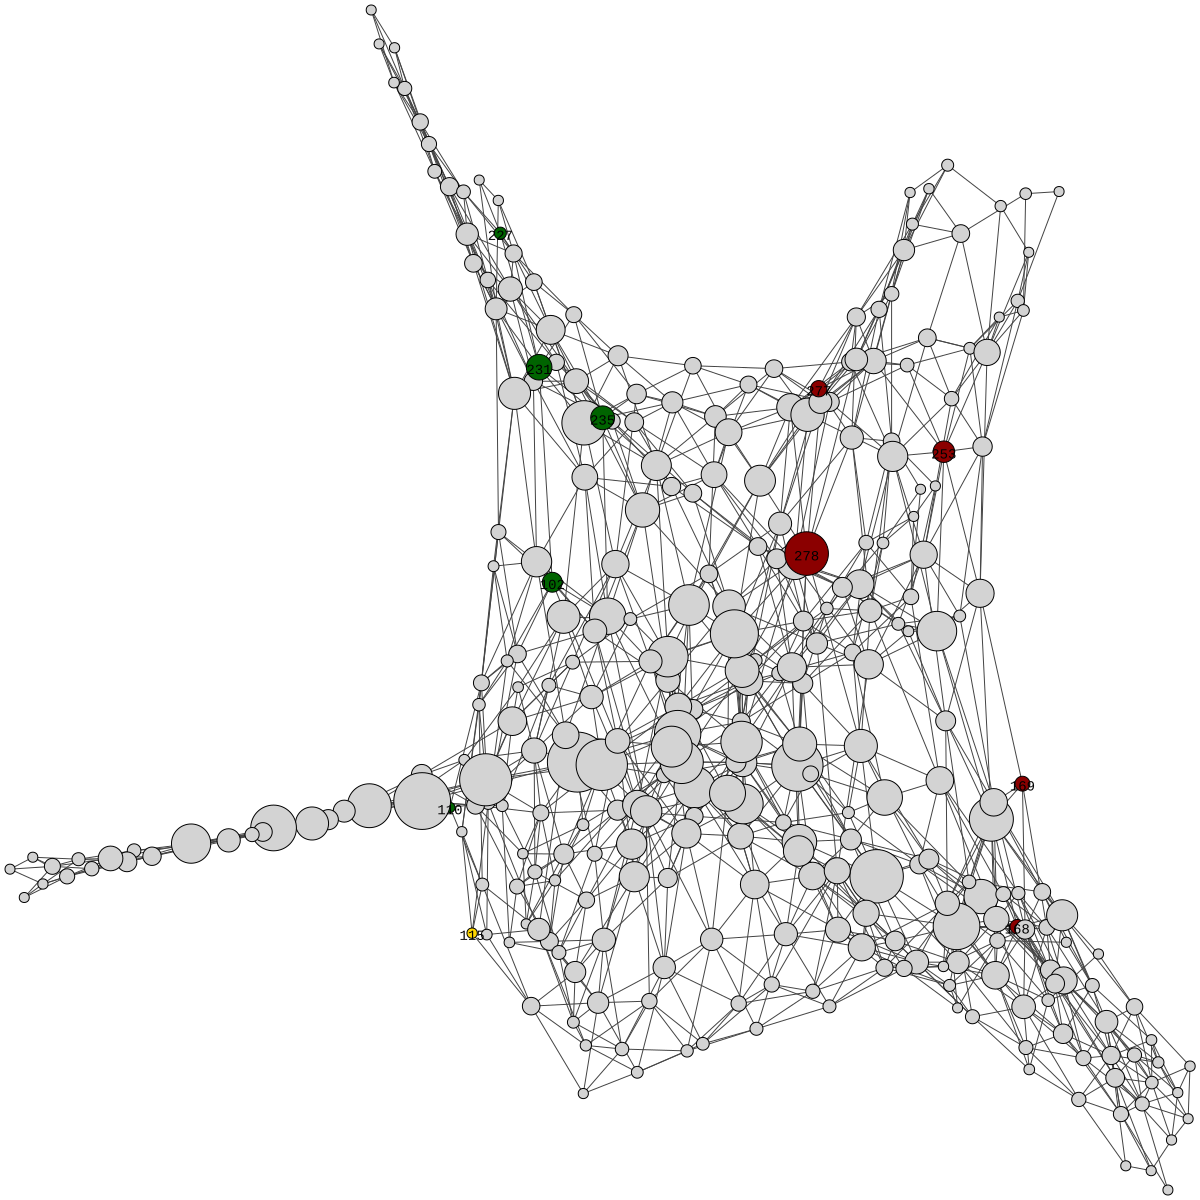

In [ ]:
# Creación de grafo de contacto y resaltar los aminoácidos de alta atención

## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_info = []  # lista de tuplas: [(chain_id, resnum, icode), ...]

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    coord = residue["CA"].get_coord()
                    resid = (chain.id, residue.id[1], residue.id[2].strip())  # ('A', 234, '')
                    CA_coord.append(coord)
                    CA_info.append(resid)

node_to_resid = {idx: resid for idx, resid in enumerate(CA_info)}
resid_to_node = {resid: idx for idx, resid in enumerate(CA_info)}


# === Árbol de búsqueda y pares ===
tree = cKDTree(CA_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(CA_coord[i] - CA_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Grafo ===

g = ig.Graph()
g.add_vertices(len(CA_coord))
g.add_edges(atom_pairsfilt)

# === Cálculo de caminos más cortos ===

shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

for a_resid in sitio_A:
    for o_resid in sitio_O:
        key_a = (chain_id, a_resid, "")
        key_o = (chain_id, o_resid, "")
        if key_a in resid_to_node and key_o in resid_to_node:
            a = resid_to_node[key_a]
            o = resid_to_node[key_o]
            try:
                path = g.get_shortest_paths(a, to=o)[0]
                if path:
                    shortest_paths.append({
                        "path": path,
                        "length": len(path),
                        "color": colors[len(shortest_paths) % len(colors)],
                        "nodes": (a_resid, o_resid),
                    })
            except:
                continue

# Calculamos el betweenness de los nodos

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])

# Escalar tamaños
g.vs["size"] = [
    10 + 50 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

user_input = input("Introduce el residuo en formato (cadena, número de residuo, código de inserción) (ejemplo: 'A', 234, ''): ")
user_resid = eval(user_input)  # Convertir el input a tupla
chain_id, resnum, icode = user_resid

key = (chain_id, resnum, icode)
if key in resid_to_node:
    node_idx = resid_to_node[key]
    centrality_score = g.vs[node_idx]["betweenness"]
    print(f"Centralidad de intermediación (betweenness) para el residuo {user_resid}: {centrality_score:.2f}")
else:
    print(f"El residuo {user_resid} no se encuentra en el grafo.")

# === Sitios de interés ===
for resid in sitio_A:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkred"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in sitio_O:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "darkgreen"
        label = resid
        g.vs[node_idx]["label"] = label

for resid in user_resid:
    key = (chain_id, resid, "")
    if key in resid_to_node:
        node_idx = resid_to_node[key]
        g.vs[node_idx]["color"] = "gold"
        label = resid
        g.vs[node_idx]["label"] = label

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1200, 1200), margin=10)